In [3]:
from openforcefield.topology import Molecule
import qcengine
import qcelemental as qcel
from qcelemental.models import AtomicInput
from qcelemental.models.common_models import Model
from openeye import oequacpac, oechem, oeomega

import numpy as np
import matplotlib.pyplot as plt

<ipython-input-3-c04c193d99fe>:1: DeprecationWarning: Importing this package as `import openforcefield.XXX` and `from openforcefield import XXX` was marked for deprecation in version `0.8.3`. From version `0.9.0` onwards this package will need to be imported as `import openff.toolkit.XXX` and `from openff.toolkit import XXX`. See the `0.8.3` release notes for more information.
  from openforcefield.topology import Molecule


In [4]:
def get_xtb(mol):
    qc_mol = mol.to_qcschema()

    xtb_model = Model(method="gfn2-xtb", basis=None)
    qc_task = AtomicInput(molecule=qc_mol, driver="energy", model=xtb_model)

    result = qcengine.compute(input_data=qc_task, program="xtb")
    
    # xtb returns energy in hartree
    return result.return_result * qcel.constants.conversion_factor("hartree", "kcal/mol")

def get_am1(mol):
    oe_mol = mol.to_openeye()
    
    calc = oequacpac.OEAM1()
    result = oequacpac.OEAM1Results()
    calc.CalcAM1(result, oe_mol)
    # am1 returns energy in kcal/mol
    return result.GetEnergy()

def getEnergies(sm_mol : str) -> ("xtb energy", "am1 energy"):
    molecule = 0
    
    try:
        molecule = Molecule.from_smiles(sm_mol, allow_undefined_stereo=True)
        molecule.generate_conformers()
    except Exception:
        return (None, None)
    
    return (get_am11(molecule), get_am1(molecule))
    

In [5]:
def get_conformers(openff_mol, max_conformers):
    mol = openff_mol.to_openeye()
    '''
    # set up omega
    omega = oeomega.OEOmega()
    omega.SetMaxConfs(max_conformers)
    omega.Build(mol)
    '''
    x = []
    for i in mol.GetConfs():
        # convert each conformer back to openff molecule
        ii = oechem.OEMol(i)
        aa = Molecule.from_openeye(ii, allow_undefined_stereo=True)
        
        x.append(aa)
        if len(x) == max_conformers:
            break
    return x

In [6]:
def calc_rmsd(vals):
    return np.sqrt(np.nanmean(vals**2,axis=0))

In [7]:
filename = "cmiles_data.txt"
mols = []
xtb_en = []
am1_en = []

ffmols = []

number = float("inf") # for every line
#number = 30
cnt = 0
pkldata = {}

with open(filename) as inputs:
    for line in inputs:
        if cnt >= number:
            break
        
        sm_mol = line.split()[0]
        
        if sm_mol == "isosmiles":
            continue
            
        try:
            molecule = Molecule.from_smiles(sm_mol, allow_undefined_stereo=True)
            molecule.generate_conformers()
            ffmols.append(get_conformers(molecule, 10))
            mols.append(sm_mol)
            pkldata[sm_mol] = {}
        except:
            print("skipped")
            continue
        cnt += 1
mols = np.array(mols)

In [31]:
b = np.full((10, len(ffmols)), np.nan)

for i, confs in enumerate(ffmols):
    xtb_en = np.zeros((len(confs)))
    am1_en = np.zeros((len(confs)))
    for j, conf in enumerate(confs):
        xtb_en[j] = get_xtb(conf)
        am1_en[j] = get_am1(conf)
        
    ratio = xtb_en / am1_en
    
    xtb_rmsd = calc_rmsd(xtb_en)
    am1_rmsd = calc_rmsd(am1_en)
    xtb_mean = np.mean(xtb_en)
    am1_mean = np.mean(am1_en)
    pkldata[mols[i]] = {
                        "xtb_rmsd" : xtb_rmsd,
                        "am1_rmsd" : am1_rmsd,
                        "xtb_mean" : xtb_mean,
                        "am1_mean" : am1_mean,
                        "spread" : np.max(ratio) - np.min(ratio),
                        "num_conformers" : len(confs),
                        "conformer_xtb_energies" : xtb_en,
                        "conformer_am1_energies" : am1_en,
                        "conformer_energy_ratios" : ratio
                       }
    b[:len(confs),i] = ratio

In [32]:
rmsd = calc_rmsd(b)
rmsd_signed = rmsd.copy()
for i in range(len(rmsd)):
    rmsd_signed[i] *= np.sign(pkldata[mols[i]]["xtb_mean"])*np.sign(pkldata[mols[i]]["am1_mean"])

    pkldata[mols[i]]["rmsd_energy_ratio"] = rmsd[i]
    pkldata[mols[i]]["rmsd_energy_ratio_signed"] = rmsd_signed[i]

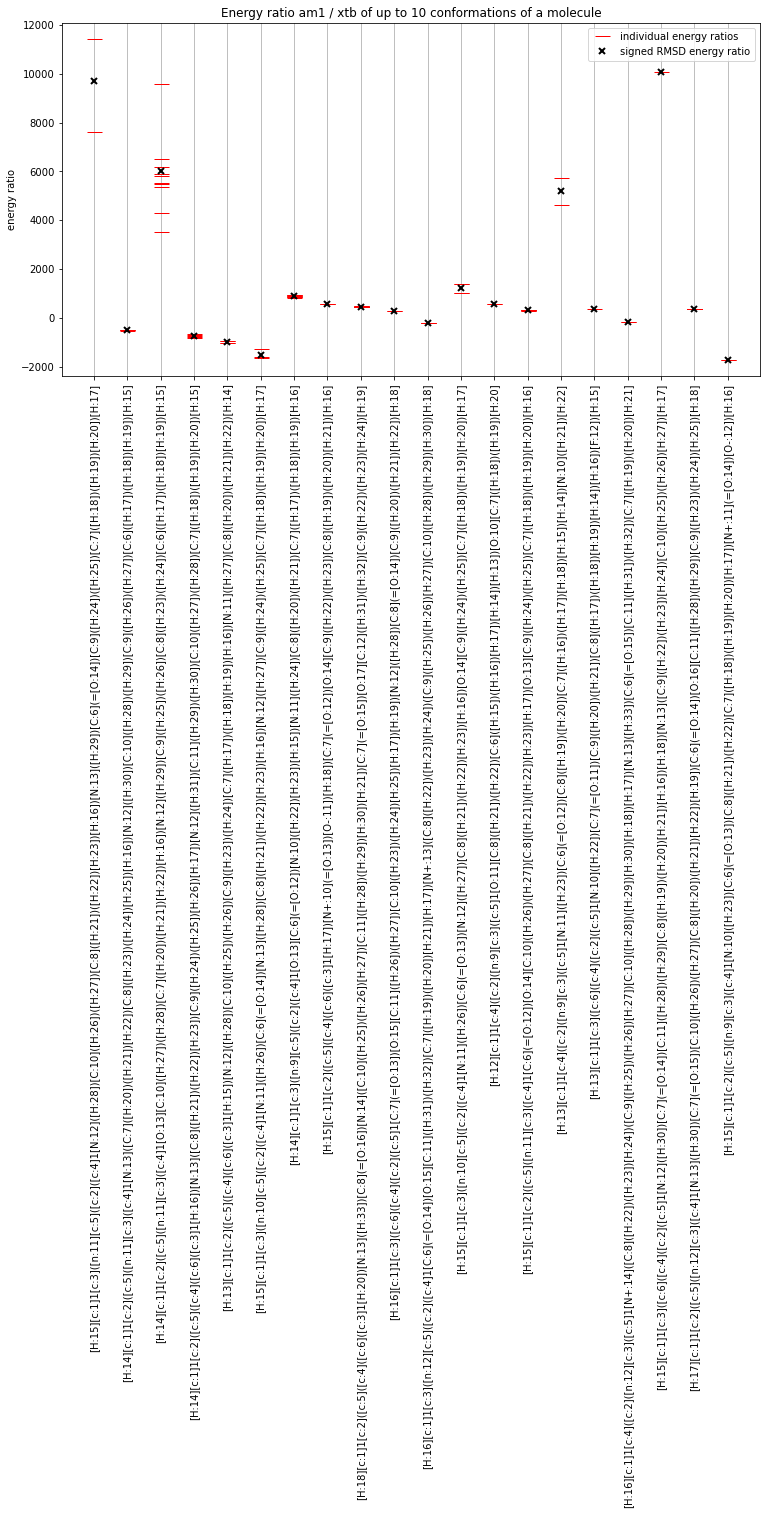

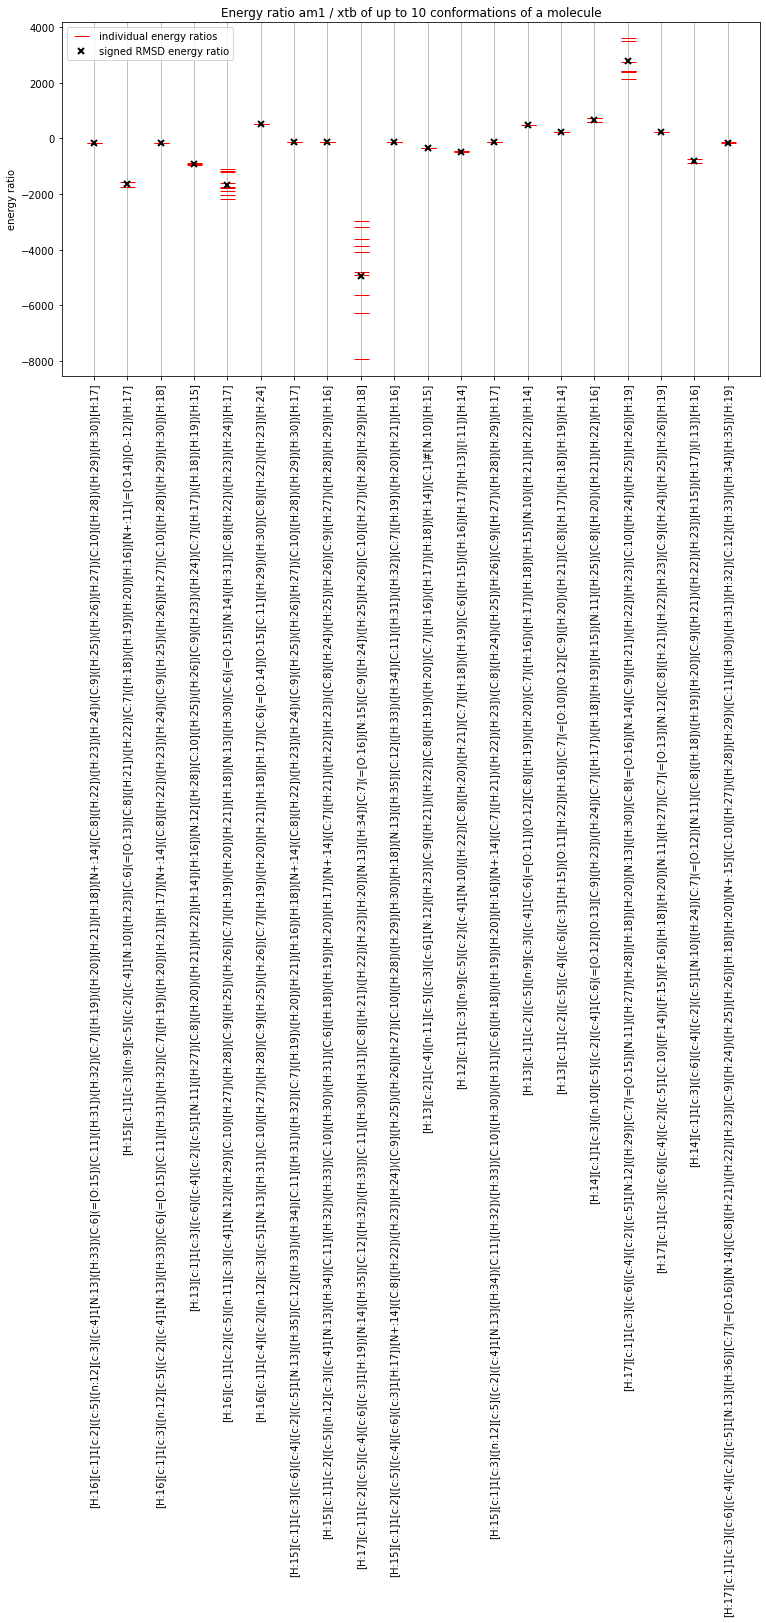

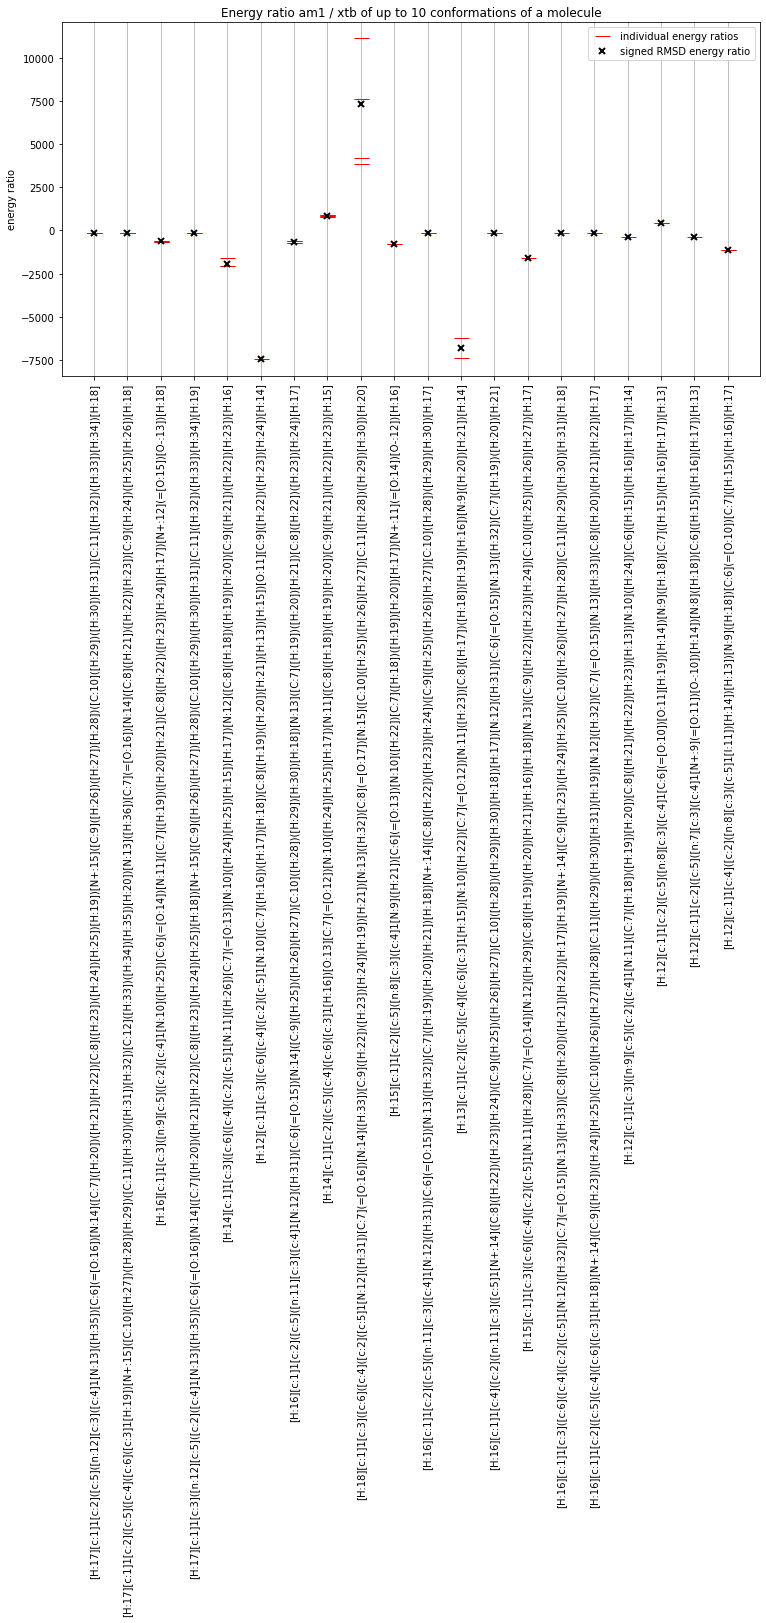

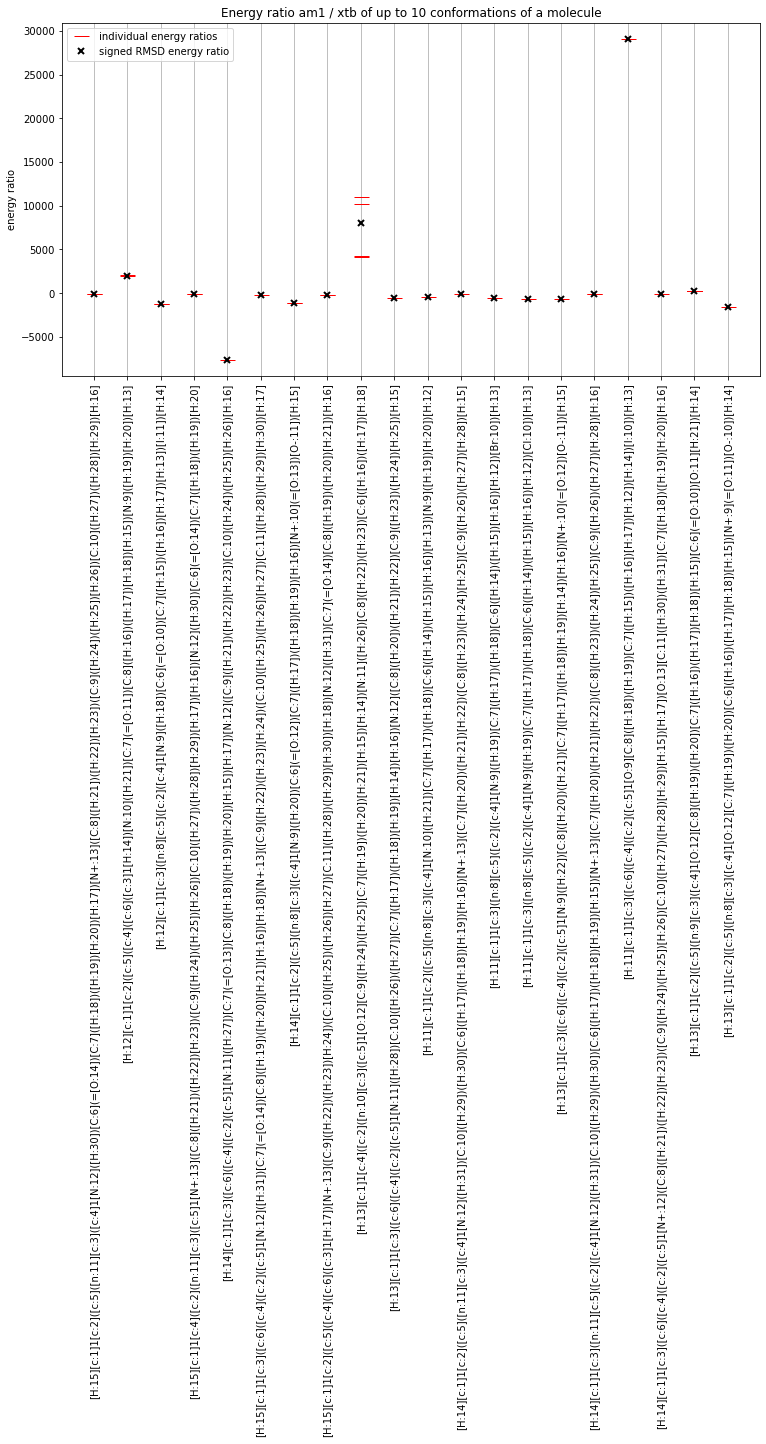

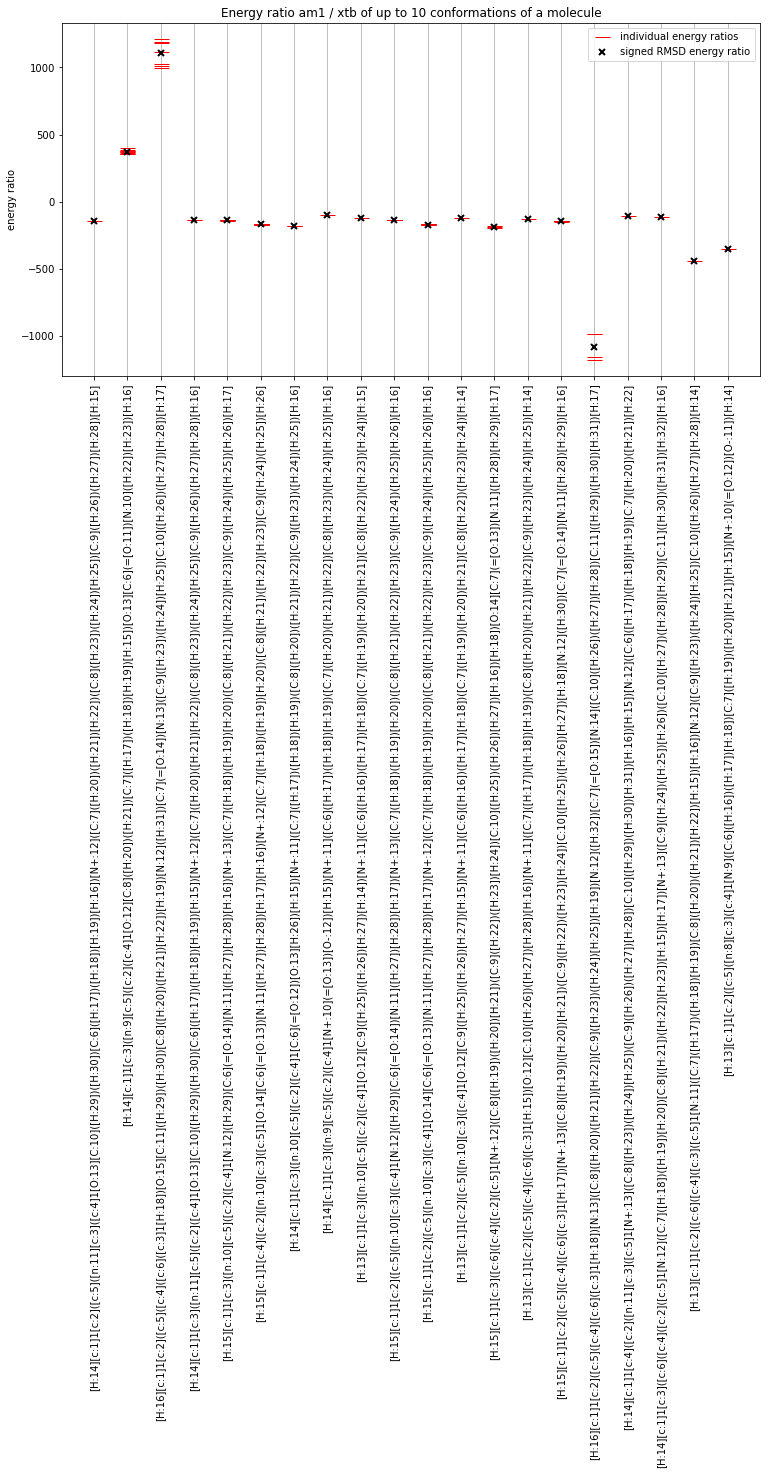

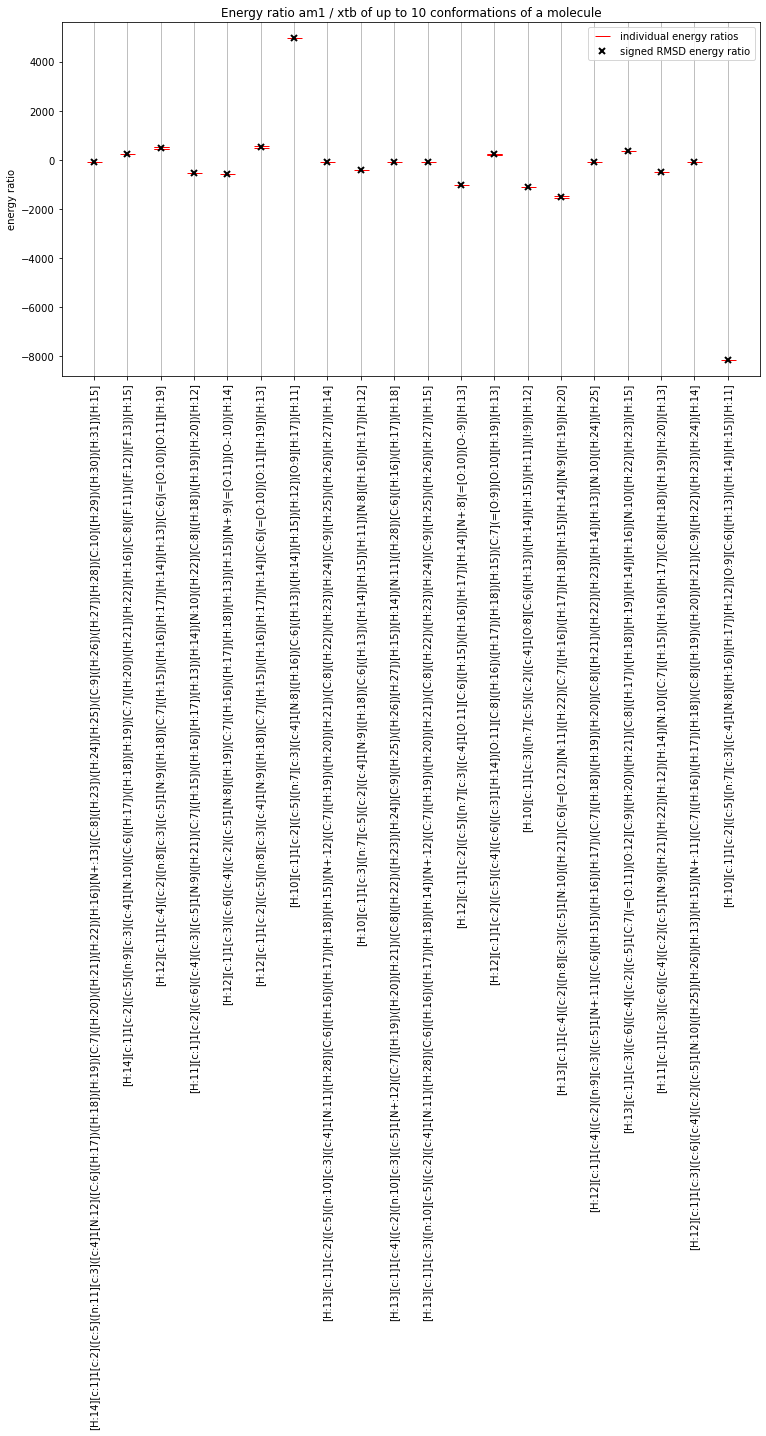

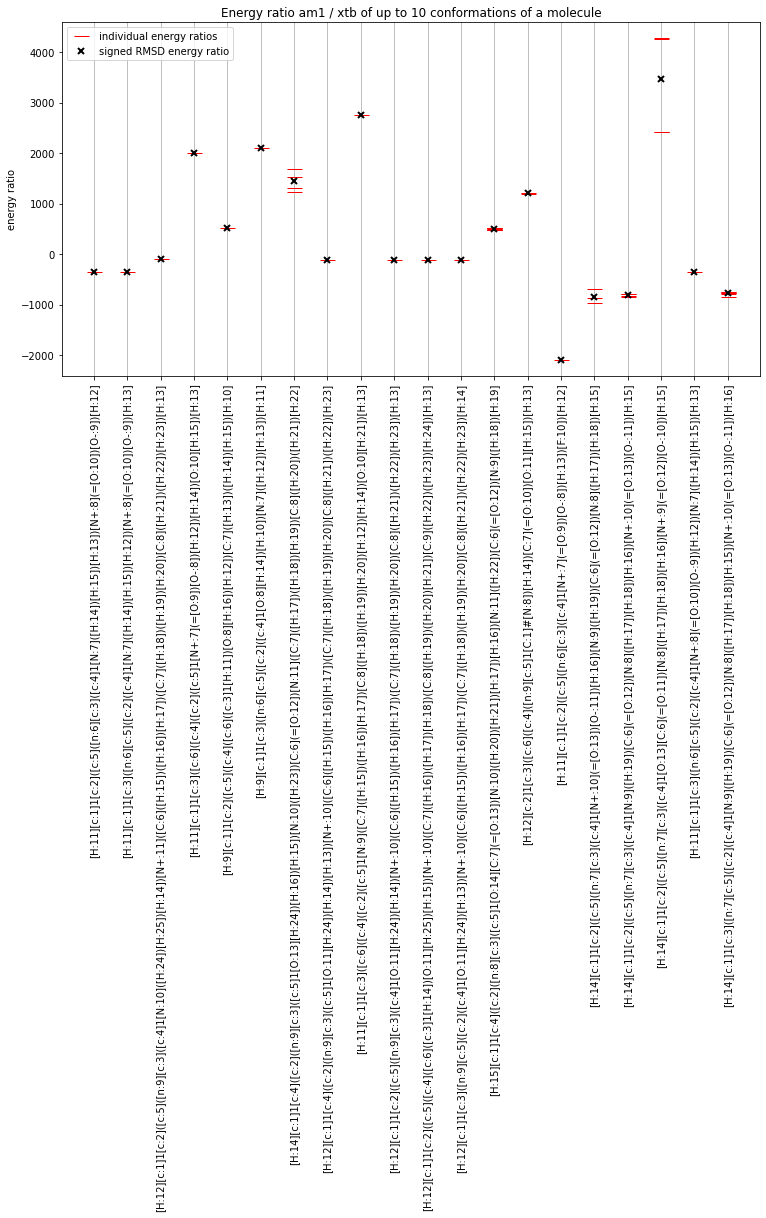

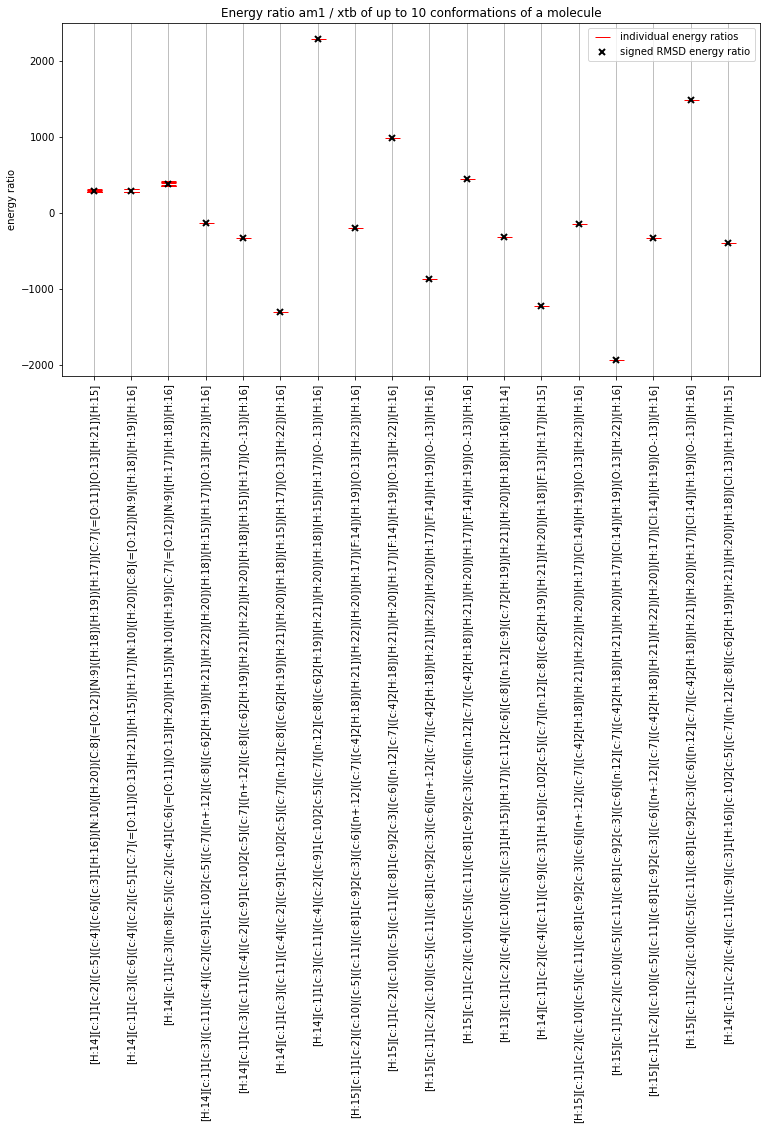

In [35]:
for i in range(int(np.ceil(len(mols)/20))):
    idxs = np.arange(i*20, min(len(mols), (i+1)*20) )
    for confidx in range(b.shape[0]):
        aa, = plt.plot(mols[idxs], b[confidx,idxs], color="red", marker="_", markersize=15, linestyle="None")

    ab, = plt.plot(mols[idxs],rmsd_signed[idxs], color="black", marker="x", markeredgewidth=2, linestyle="None")

    plt.legend((aa, ab), ("individual energy ratios", "signed RMSD energy ratio"))
    plt.title("Energy ratio am1 / xtb of up to 10 conformations of a molecule")
    plt.ylabel("energy ratio")
    plt.xticks(rotation=90)
    fig = plt.gcf()
    fig.set_size_inches(12.5, 6.5)
    plt.grid(axis="x")
    plt.show()

Note: it seems like xtb calculated energy is always negative. This means in the chart when the energy ratio is positive, the am1 calculated energy is negative, and when the enrgy ratio is negative, the am1 calculated energy is positive.

In [14]:
# pickle the data
import pickle
'''
pickle format

{
    smiles string of molecule :
    {
        "spread" : float,                       # the difference between the largest and smallest energy ratios 
        "num_conformers" : int,                 # the number of conformations sampled, up to 10
        "conformer_xtb_energies" : [float],     # array of xtb-calculated energies for each conformer
        "conformer_am1_energies" : [float],     # array of am1-calculated energies for each conformer
        "conformer_energy_ratios" : [float],    # energy ratios
        "rmsd_energy_ratio" : float             # the average energy ratio
    }
}
'''
with open('xtb_am1_benchmark.pickle', 'wb') as pkfile:
    pickle.dump(pkldata, pkfile)

In [15]:
# loading pickle file
with open('xtb_am1_benchmark.pickle', 'rb') as handle:
    pklopen = pickle.load(handle)
    print(pklopen)

{'[H:15][c:1]1[c:3]([n:11][c:5]([c:2]([c:4]1[N:12]([H:28])[C:10]([H:26])([H:27])[C:8]([H:21])([H:22])[H:23])[H:16])[N:13]([H:29])[C:6](=[O:14])[C:9]([H:24])([H:25])[C:7]([H:18])([H:19])[H:20])[H:17]': {'spread': 3816.1926417113436, 'num_conformers': 2, 'conformer_xtb_energies': array([-26302.60245254, -26301.80550344]), 'conformer_am1_energies': array([-3.45775837, -2.3025246 ]), 'conformer_energy_ratios': array([ 7606.83647209, 11423.0291138 ]), 'rmsd_energy_ratio': 9704.368996692441}, '[H:14][c:1]1[c:2]([c:5]([n:11][c:3]([c:4]1[N:13]([C:7]([H:20])([H:21])[H:22])[C:8]([H:23])([H:24])[H:25])[H:16])[N:12]([H:30])[C:10]([H:28])([H:29])[C:9]([H:26])([H:27])[C:6]([H:17])([H:18])[H:19])[H:15]': {'spread': 38.0512899122063, 'num_conformers': 4, 'conformer_xtb_energies': array([-24377.38831448, -24377.39025417, -24376.44744376, -24374.13654433]), 'conformer_am1_energies': array([45.88056256, 48.43456373, 47.78844556, 49.41322729]), 'conformer_energy_ratios': array([-531.32278583, -503.3056639